In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from prettytable import PrettyTable

In [60]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]
# mean = [0.5, 0.5, 0.5]
# std = [0.5, 0.5, 0.5]

train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)
                                       ])


test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)
                                       ])

In [61]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [62]:

print("mean: ", train.data.mean())
sample, label = train[0]
loader = torch.utils.data.DataLoader(train, batch_size=len(train))
data, label = next(iter(loader))
print("formatted mean", data.mean(dim = [0,2,3]))
print("formatted std", data.std(dim = [0, 2, 3]))


mean:  120.70756512369792
formatted mean tensor([-0.0172, -0.0357, -0.1069])
formatted std tensor([0.4941, 0.4870, 0.5232])


In [63]:
SEED = 2

# CUDA?
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
cuda = torch.cuda.is_available()
print("GPU Available?", device)

# For reproducibility
torch.manual_seed(SEED)

if device == "cuda":
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

# Pretty table for collecting all the accuracy and loss parameters in a table
log_table = PrettyTable()

GPU Available? mps


In [64]:
print(f"number of training samples : {len(train)}")
print(f"number of training samples : {len(test)}")
print(f"number of classes : {train.classes}")

number of training samples : 50000
number of training samples : 10000
number of classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

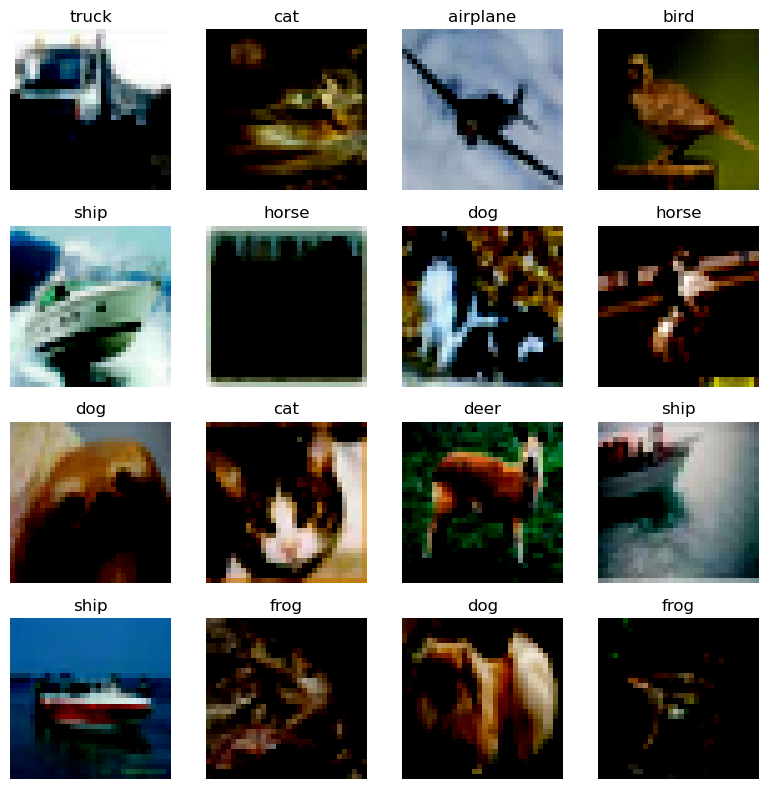

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Function to display a grid of images
def show_images(dataset, num_images=16):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.ravel()
    for i in range(num_images):
        index = np.random.randint(0, len(dataset))
        image, label = dataset[index]
        axes[i].imshow(np.transpose(image.numpy(), (1, 2, 0)))  # Convert from Tensor to NumPy
        axes[i].set_title(dataset.classes[label])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display sample training images
show_images(train)

In [66]:
image, label = train[0]
print(f"Image Shape: {image.shape}")
print(f"Label : {label} ({train.classes[label]})")

Image Shape: torch.Size([3, 32, 32])
Label : 6 (frog)


In [67]:
from collections import Counter

labels = [label for _, label in train]
class_counts = Counter(labels)
print(class_counts)
class_counts.items()
for cls, count in class_counts.items():
    print(f"{train.classes[cls]} : {count}")

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})
frog : 5000
truck : 5000
deer : 5000
automobile : 5000
bird : 5000
horse : 5000
ship : 5000
cat : 5000
dog : 5000
airplane : 5000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


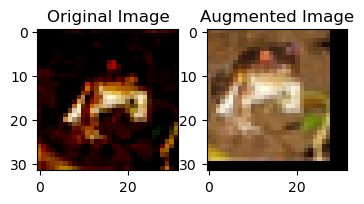

In [68]:
transform_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor()
])

# Apply augmentation to a sample image
augment_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_augment)
aug_image, _ = augment_dataset[0]

# Display original and augmented images
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
ax[0].imshow(np.transpose(image.numpy(), (1, 2, 0)))
ax[0].set_title("Original Image")
ax[1].imshow(np.transpose(aug_image.numpy(), (1, 2, 0)))
ax[1].set_title("Augmented Image")
plt.show()


In [69]:
print("Dataset statistics")
print("Shape : ", train.data.shape)
print("min : ", train.data.min().item())
print("max :", train.data.max().item())
print("mean: ", train.data.mean())
print("variance : ", train.data.std())
print("variance : ", train.data.var())


Dataset statistics
Shape :  (50000, 32, 32, 3)
min :  0
max : 255
mean:  120.70756512369792
variance :  64.1500758911213
variance :  4115.232236836622


In [133]:
dropout_value = 0.1
# CNN Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.convblock1 = nn.Sequential(
            #input size : 3x32x32
            # Block - 1, Layer - 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(), # ouptput: 32, RF: 3
            nn.Dropout(dropout_value),

            # Layer 2 - depthwise separable convolution
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=1, padding=1, groups=32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(), #output: 32, RF: 5
            


            # #Layer - 3
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(), # output: 32, RF: 7
            nn.Dropout(dropout_value),

            # Stride-2 Convolution - downsampling
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(), # output: 16, RF: 9
            nn.Dropout(dropout_value),
        ) 

        self.transition1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU() #output : 16, RF:9
        )
        self.convblock2 = nn.Sequential(

            #Block - 2, Layer - 1
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(3, 3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(), #output: 16, RF: 13
            nn.Dropout(dropout_value),

            # Block - 2, Layer - 2
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(3, 3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(), #output: 16, RF: 17
            nn.Dropout(dropout_value),

            # stride = 2 convolution downsampling
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(), #output: 8, RF: 21
            nn.Dropout(dropout_value),
        ) 

        self.transition2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU() #output:8, RF:21
        )

        self.convblock3 = nn.Sequential(

            #Block - 3, Layer - 1
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(), #output: 8, RF: 29
            nn.Dropout(dropout_value),

            # Block - 3, Layer - 2
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(), #output: 8, RF: 37
            nn.Dropout(dropout_value),

            # dilated convolution here
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=2, dilation=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(), #output: 8, RF: r_out = r_in + (k-1)*j_in = 37 + 4*4 = 53
            nn.Dropout(dropout_value),

            # #Block - 3, stride-2 after dilation
            # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, bias=False),
            
            #nn.BatchNorm2d(64),
            #nn.ReLU(), #output: 4, RF: 61
            #nn.Dropout(dropout_value),

        ) 

        # self.transition3 = nn.Sequential(
        #     nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU()
        # )

        # self.convblock4 = nn.Sequential(

        #     #Block - 4, Layer - dilation
        #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1, dilation=2, bias=False),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(), #output: 4, RF: 59
        # ) 

        self.outputblock = nn.Sequential(
            nn.AvgPool2d(kernel_size=4),
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) 



    def forward(self, x):
        x = self.convblock1(x)
        x = self.transition1(x)
        x = self.convblock2(x)
        x = self.transition2(x)
        x = self.convblock3(x)
        #x = self.transition3(x)
        #x = self.convblock4(x)
        x = self.outputblock(x)
        x = x.view(-1, 10)
        return x


In [134]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
cuda = torch.device("cuda" if use_cuda else "cpu")
print(cuda)
model = Net().to(cuda)
summary(model, input_size=(3, 32, 32))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             320
            Conv2d-6           [-1, 32, 32, 32]           1,056
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1,

In [135]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    criterion = nn.CrossEntropyLoss()
    loss = criterion(y_pred, target)
    #loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [132]:
from torch.optim.lr_scheduler import StepLR

print("model running on: ", device)
log_table = PrettyTable()
log_table.field_names = ["Epoch", "Training Accuracy", "Test Accuracy", "Diff", "Training Loss", "Test Loss"]

model =  Net().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model, device, test_loader)
    log_table.add_row([epoch, f"{train_acc[-1]:.2f}%", f"{test_acc[-1]:.2f}%", f"{float(train_acc[-1]) - float(test_acc[-1]):.2f}" ,f"{train_losses[-1]:.4f}", f"{test_losses[-1]:.4f}"])
print(log_table)

model running on:  mps
EPOCH: 0


Loss=0.8590423464775085 Batch_id=390 Accuracy=49.87: 100%|██████████| 391/391 [00:32<00:00, 11.85it/s]



Test set: Average loss: -2.0363, Accuracy: 4483/10000 (44.83%)

EPOCH: 1


Loss=0.7587553262710571 Batch_id=390 Accuracy=68.15: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]



Test set: Average loss: -2.7597, Accuracy: 5720/10000 (57.20%)

EPOCH: 2


Loss=0.6115325689315796 Batch_id=390 Accuracy=75.13: 100%|██████████| 391/391 [00:33<00:00, 11.78it/s]



Test set: Average loss: -3.4143, Accuracy: 6819/10000 (68.19%)

EPOCH: 3


Loss=0.39528998732566833 Batch_id=390 Accuracy=79.16: 100%|██████████| 391/391 [00:33<00:00, 11.78it/s]



Test set: Average loss: -4.0424, Accuracy: 7570/10000 (75.70%)

EPOCH: 4


Loss=0.620529055595398 Batch_id=390 Accuracy=81.75: 100%|██████████| 391/391 [00:32<00:00, 11.98it/s]  



Test set: Average loss: -4.1664, Accuracy: 7739/10000 (77.39%)

EPOCH: 5


Loss=0.5610777139663696 Batch_id=390 Accuracy=83.74: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s] 



Test set: Average loss: -4.6787, Accuracy: 7907/10000 (79.07%)

EPOCH: 6


Loss=0.5187827944755554 Batch_id=390 Accuracy=85.58: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s] 



Test set: Average loss: -4.5518, Accuracy: 7847/10000 (78.47%)

EPOCH: 7


Loss=0.41290244460105896 Batch_id=390 Accuracy=86.95: 100%|██████████| 391/391 [00:33<00:00, 11.82it/s]



Test set: Average loss: -4.8439, Accuracy: 7985/10000 (79.85%)

EPOCH: 8


Loss=0.34806543588638306 Batch_id=390 Accuracy=88.23: 100%|██████████| 391/391 [00:33<00:00, 11.81it/s]



Test set: Average loss: -5.1528, Accuracy: 7949/10000 (79.49%)

EPOCH: 9


Loss=0.4200192391872406 Batch_id=390 Accuracy=89.35: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s] 



Test set: Average loss: -5.3109, Accuracy: 7972/10000 (79.72%)

+-------+-------------------+---------------+-------+---------------+-----------+
| Epoch | Training Accuracy | Test Accuracy |  Diff | Training Loss | Test Loss |
+-------+-------------------+---------------+-------+---------------+-----------+
|   0   |       49.87%      |     44.83%    |  5.04 |     0.8590    |  -2.0363  |
|   1   |       68.15%      |     57.20%    | 10.95 |     0.7588    |  -2.7597  |
|   2   |       75.13%      |     68.19%    |  6.94 |     0.6115    |  -3.4143  |
|   3   |       79.16%      |     75.70%    |  3.46 |     0.3953    |  -4.0424  |
|   4   |       81.75%      |     77.39%    |  4.36 |     0.6205    |  -4.1664  |
|   5   |       83.74%      |     79.07%    |  4.67 |     0.5611    |  -4.6787  |
|   6   |       85.58%      |     78.47%    |  7.11 |     0.5188    |  -4.5518  |
|   7   |       86.95%      |     79.85%    |  7.10 |     0.4129    |  -4.8439  |
|   8   |       88.23%      |    